In [1]:
import numpy as np
import tensorflow as tf
import urllib.request
import os
import zipfile
from PIL import Image 
from tqdm import tqdm
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from IPython.display import clear_output

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 933505213849517205]

In [3]:
def preprocess(img):
    return (img / 127.5) - 1

#作成したpreprocess処理をもとに戻す。
def deprocess(img):
    img = img.copy()
    img /= 2.
    img += 0.5
    img *= 255.
    return np.clip(img, 0, 255).astype('uint8')

# 画像を表示する。
def show(img):
    plt.figure(figsize=(12,12))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)

In [4]:
def forward(img):
    # バッチを作成
    img_batch = tf.expand_dims(img, axis=0)

    return feat_extraction_model(img_batch)

def calc_loss(layer_activations):
    total_loss = 0
    for act in layer_activations:
        # 要素の平均値を算出する
        loss = tf.math.reduce_mean(act)

        # レイヤー内の要素数で正規化を行う。
        loss /= np.prod(act.shape)
        total_loss += loss
        return total_loss

2
(667, 375, 3)


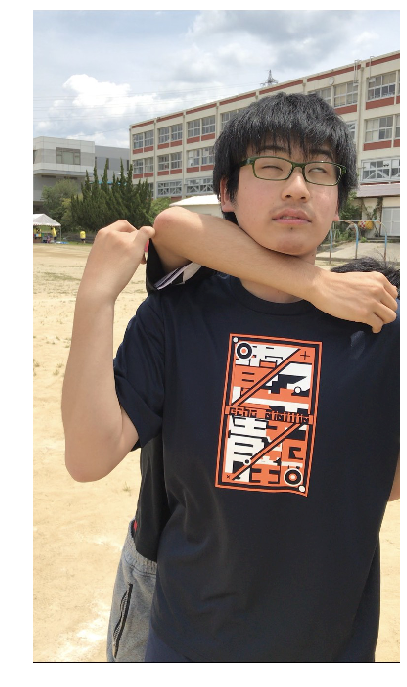

In [19]:
img = Image.open("IMG_0415.JPG")
w = img.size[0]
h = img.size[1]
print(np.gcd.reduce(img.size))
lcm = np.gcd.reduce(img.size)
img = img.resize((int(w/lcm),int(h/lcm)))
img = preprocess(np.array(img))
print(img.shape)
show(deprocess(img))

In [20]:
inception_v3 = tf.keras.applications.InceptionV3(weights='imagenet',include_top=False)

# inceptionv3内で利用するレイヤを定義
names = ['mixed3', 'mixed4', 'mixed5', 'mixed6', 'mixed7', 'mixed8','mixed9']
layers = [inception_v3.get_layer(name).output for name in names]

# 特徴量を抽出するモデルを作成する。
feat_extraction_model = tf.keras.Model(inputs=inception_v3.input, outputs=layers)

Step 180, loss 0.000002


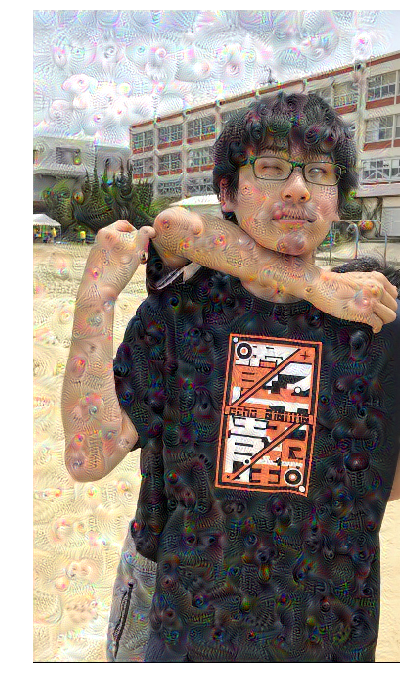


  2%|█▍                                                                          | 184/10000 [11:21<9:50:14,  3.61s/it]

In [ ]:
img = tf.Variable(img)

# 何回回すかを指定
steps = 10000

for step in tqdm(range(steps)):

    with tf.GradientTape() as tape:    
        activations = forward(img)
        loss = calc_loss(activations)

    #勾配を計算する。
    gradients = tape.gradient(loss, img)

    # 勾配の正規化を行う
    gradients /= gradients.numpy().std() + 1e-8 

    #imgをアップデートする。
    img.assign_add(gradients)

    if step % 10 == 0:
        clear_output()
        print ("Step %d, loss %f" % (step, loss))
        show(deprocess(img.numpy()))
        plt.show()


# 結果を出力する
clear_output()
show(deprocess(img.numpy()))

In [1]:
import tensorflow as tf
tf.__version__

'1.9.0'